In [1]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# TruncatedSVD from sklearn
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

In [2]:
# list of documents
a1 = "He is a good dog"
a2 = "The dog is too lazy"
a3 = "That is a brown cat"
a4 = "Cats are very active"
a5 = "I have brown cat and dog"

df = pd.DataFrame()
df["documents"] = [a1,a2,a3,a4,a5]
df

,documents
0,He is a good dog
1,The dog is too lazy
2,That is a brown cat
3,Cats are very active
4,I have brown cat and dog


In [3]:
# import english
import en_core_web_sm
nlp = en_core_web_sm.load()

In [4]:
# nettoyer la base de données
# enlever la ponctuation
df["clean_documents"] = df["documents"].str.replace(r"[^A-Za-z0-9]+"," ")
# passer en lower case
df["clean_documents"] = df["clean_documents"].fillna('').apply(lambda x: x.lower())
df

,documents,clean_documents
0,He is a good dog,he is a good dog
1,The dog is too lazy,the dog is too lazy
2,That is a brown cat,that is a brown cat
3,Cats are very active,cats are very active
4,I have brown cat and dog,i have brown cat and dog


In [5]:
# tokeniser chaque document: décomposer un texte brut en unités plus petites appelées tokens. Ces tokens peuvent être des mots, des phrases, ou même des caractères, selon les besoins de l’analyse.
    # Préparer les données pour le traitement
    # Isoler les unités significatives
    # Réduction de la complexité
    # Étape préalable à d’autres traitements
        # Lemmatisation (réduction des mots à leur forme de base)
        # Suppression des mots vides (stop words)
        # Analyse de la fréquence des mots
        # Création de représentations vectorielles (TF-IDF, Word2Vec, etc.)

In [6]:
# tokenisation
tokenized_doc = df["clean_documents"].fillna('').apply(lambda x: nlp(x))

In [7]:
# lemmatisation
from spacy.lang.en.stop_words import STOP_WORDS

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])
tokenized_doc

0          [good, dog]
1          [dog, lazy]
2         [brown, cat]
3        [cat, active]
4    [brown, cat, dog]
Name: clean_documents, dtype: object

In [8]:
# scikitlearn: n'attend pas des listes de token pour pouvoir travailler
# il attend pour chaque ligne une chaine de caractères qui contient le tout => il faut detokeniser

# faire appel à la méthode join
# exemple:

l = ["cat","dog"]
' '.join(l)

'cat dog'

In [9]:
df["clean_documents"] = tokenized_doc.apply(lambda x: ' '.join(x))
df

,documents,clean_documents
0,He is a good dog,good dog
1,The dog is too lazy,dog lazy
2,That is a brown cat,brown cat
3,Cats are very active,cat active
4,I have brown cat and dog,brown cat dog


In [10]:
# Désormais on a une chaine de caractères avec tous les mots
# la colonne clean_documents est prête pour lancer un TFIDF

# Création de représentations vectorielles TF-IDF

# Déclarer une instance de la classe TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
# application de la représentation vectorielle
X = vectorizer.fit_transform(df["clean_documents"])
# supprimer la densité de la matrice
dense = X.toarray()
dense

array([[0.        , 0.        , 0.        , 0.55645052, 0.83088075,
        0.        ],
       [0.        , 0.        , 0.        , 0.55645052, 0.        ,
        0.83088075],
       [0.        , 0.76944707, 0.63871058, 0.        , 0.        ,
        0.        ],
       [0.83088075, 0.        , 0.55645052, 0.        , 0.        ,
        0.        ],
       [0.        , 0.64846263, 0.53828256, 0.53828256, 0.        ,
        0.        ]])

In [11]:
# 6 colonnes = le document contient 6 mots
# savoir quel est le vocabulaire utilisé
vectorizer.vocabulary_

{'good': 4, 'dog': 3, 'lazy': 5, 'brown': 1, 'cat': 2, 'active': 0}

In [12]:
# les chiffres sont les emplacements de la colonne

# autre méthode = get.feature.name
vectorizer.get_feature_names_out()
# noms sont cette fois ci dans l'ordre des colonnes

array(['active', 'brown', 'cat', 'dog', 'good', 'lazy'], dtype=object)

In [13]:
# on va pouvoir appliquer un algo trunkedSVD
# n_components = nb de topics que l'on souhaite dégager

# déclarer une instance de la classe SVD
svd_model = TruncatedSVD(n_components=2, n_iter=100, random_state=0)
# fit_transform sur la matrice x
lsa = svd_model.fit_transform(X)
lsa

# 5 lignes 2 colonnes => matrice U = autant de lignes que de doc, autant de colonnes que de topics
# 2ème ligne = représente le deuxieme document et 0.71997811 explique que ce document est plus lié au deuxième topic qu'au premier

array([[ 0.34138342,  0.71997811],
       [ 0.34138342,  0.71997811],
       [ 0.86094909, -0.36598366],
       [ 0.5166659 , -0.38500462],
       [ 0.94941174,  0.02363029]])

In [14]:
# visualiser un point pour chaque docuement, x = valeur premier topic, y = valeur deuxieme topic

# mettre dans un DF pour commencer
topic_encoded_df = pd.DataFrame(lsa, columns= ["topic_1", "topic_2"])
topic_encoded_df['documents'] = df['clean_documents']
topic_encoded_df


,topic_1,topic_2,documents
0,0.341383,0.719978,good dog
1,0.341383,0.719978,dog lazy
2,0.860949,-0.365984,brown cat
3,0.516666,-0.385005,cat active
4,0.949412,0.023630,brown cat dog


<Axes: xlabel='topic_1', ylabel='topic_2'>

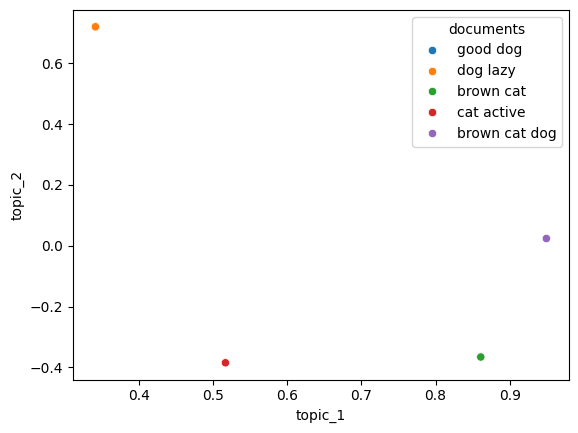

In [15]:
# faire un scatterplot
sns.scatterplot(x='topic_1', y='topic_2', data=topic_encoded_df, hue='documents')

In [16]:
# plus le point est proche des axes, plus le document est proche du topic
# utiliser la distance cosinus pour vérifier l'espace entre l'axe et le point = permet de vérifier la proximité du point avec le topic
# ici le topic 1 a l'air de pencher vers le mot chat

In [ ]:
# identifier les coordonnées de chaque mot vs topic:
topic = pd.DataFrame(svd_model.components_, index = ['topic_1', 'topic_2'], columns= vectorizer.get_feature_names_out())
topic

,active,brown,cat,dog,good,lazy
topic_1,0.200354,0.596512,0.629338,0.415831,0.132383,0.132383
topic_2,-0.242441,-0.201810,-0.329886,0.616903,0.453377,0.453377


In [22]:
# pour faure le graph avec seaborn, il vaut mieux travailler avec la transposé de la matrice:
topic_t = topic.transpose()
topic_t

,topic_1,topic_2
active,0.200354,-0.242441
brown,0.596512,-0.201810
cat,0.629338,-0.329886
dog,0.415831,0.616903
good,0.132383,0.453377
lazy,0.132383,0.453377


In [23]:
# pour mettre les mots dans une colonne, on peut utiliser resent.index
topic_t = topic_t.reset_index()
topic_t

,index,topic_1,topic_2
0,active,0.200354,-0.242441
1,brown,0.596512,-0.201810
2,cat,0.629338,-0.329886
3,dog,0.415831,0.616903
4,good,0.132383,0.453377
5,lazy,0.132383,0.453377


In [25]:
# changer le nom de la colonne
topic_t = topic_t.rename({'index':'word'}, axis = 1)
topic_t

,word,topic_1,topic_2
0,active,0.200354,-0.242441
1,brown,0.596512,-0.201810
2,cat,0.629338,-0.329886
3,dog,0.415831,0.616903
4,good,0.132383,0.453377
5,lazy,0.132383,0.453377


<Axes: xlabel='topic_1', ylabel='topic_2'>

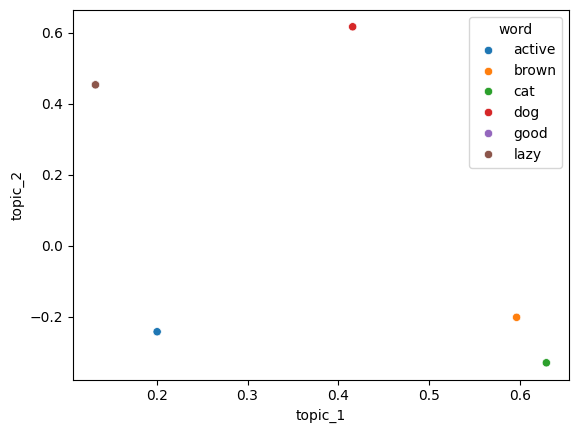

In [28]:
sns.scatterplot(x='topic_1', y='topic_2', data = topic_t, hue = 'word')